In [1]:
import os
import pickle
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
sem_df = pd.read_csv('../data/semmedVER30_A_clean.csv')

/home/mmayers/software/anaconda3/envs/ml/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Rows: {:,}'.format(sem_df.shape[0]))
print('Cols: {}'.format(sem_df.shape[1]))

Rows: 97,118,423
Cols: 12


In [4]:
sem_df.head()

,PREDICATION_ID,SENTENCE_ID,PMID,PREDICATE,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY
0,61,128,14420371,ISA,C0026879,Mutagens,hops,1,C0220806,Chemicals,chem,1
1,62,116,5659339,PART_OF,C0017725,Glucose,bacs,1,C0022378,jejunum,bpoc,1
2,63,146,12255310,PROCESS_OF,C0006147,Breast Feeding,orgf,1,C0020114,Human,humn,1
3,64,170,12305488,TREATS,C0279494,Oestrogen therapy,topp,1,C0043210,Woman,popg,1
4,65,116,5659339,PROCESS_OF,C0232338,Blood flow,orgf,1,C0012984,Canis familiaris,mamm,1


## Count PMIDs

In [5]:
from collections import defaultdict

In [6]:
pmids = defaultdict(set)

for tup in tqdm(sem_df.itertuples(False, None), total=len(sem_df)):
    pmid = tup[2]
    sub = tup[4]
    pred = tup[3]
    obj = tup[8]
    
    pmids[(sub, pred, obj)].add(pmid)

100%|██████████| 97118423/97118423 [05:22<00:00, 301594.48it/s]


In [7]:
pmids[('C0232338', 'PROCESS_OF', 'C0012984')]

{16990217,
 2867218,
 23,
 696351,
 12124197,
 7102508,
 16436,
 3235894,
 9756732,
 786496,
 7594053,
 9863238,
 2138185,
 1441869,
 1269846,
 6864987,
 508009,
 7733353,
 4030591,
 7176320,
 5922945,
 4825221,
 26058891,
 7184524,
 1884300,
 1982609,
 622740,
 270486,
 5324955,
 3440796,
 10027166,
 3342495,
 11247775,
 8357,
 6127791,
 6144176,
 3891380,
 2965695,
 3825857,
 5357762,
 4522182,
 9879753,
 2859210,
 6422733,
 2965715,
 7954653,
 8519902,
 18202845,
 13000928,
 344293,
 1433833,
 6406410,
 1122572,
 6332687,
 15261969,
 2523414,
 1777945,
 7143714,
 500003,
 6881580,
 8929580,
 16892205,
 4587823,
 1597746,
 131380,
 1016119,
 2801977,
 6373692,
 15139132,
 6373694,
 14885185,
 7127361,
 2744655,
 8151388,
 16580958,
 33121,
 12755300,
 3301739,
 844141,
 844147,
 22135160,
 8397178,
 3613053,
 5652866,
 1016195,
 7324037,
 4678026,
 6455694,
 5480847,
 631185,
 3301787,
 3621283,
 6218152,
 688562,
 65975,
 156090,
 1425857,
 5792197,
 6267347,
 1499605,
 9585114,
 90

In [8]:
%%time
grpd = sem_df.groupby(['SUBJECT_CUI', 'PREDICATE', 'OBJECT_CUI'])

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 666 µs


In [9]:
%%time
counts = grpd['PMID'].nunique()

CPU times: user 4min 49s, sys: 796 ms, total: 4min 50s
Wall time: 4min 49s


In [10]:
counts = counts.to_frame()

In [11]:
counts = counts.reset_index()

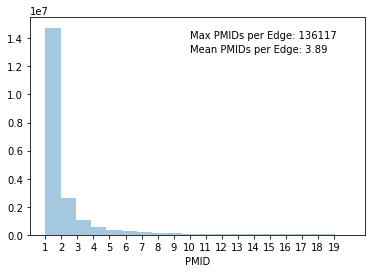

In [12]:
sns.distplot(counts[counts['PMID'] < 21]['PMID'], bins=20, kde=False)
plt.xticks(np.arange(1, 20, 1))
plt.text(10, 1.4e7, 'Max PMIDs per Edge: {}'.format(counts['PMID'].max()))
plt.text(10, 1.3e7, 'Mean PMIDs per Edge: {:1.2f}'.format(counts['PMID'].mean()));

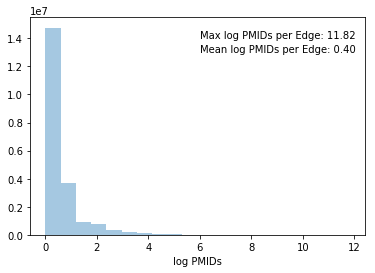

In [13]:
log_counts = np.log(counts['PMID'])
sns.distplot(log_counts, bins=20, kde=False)
plt.xlabel('log PMIDs');
plt.text(6, 1.4e7, 'Max log PMIDs per Edge: {:1.2f}'.format(log_counts.max()))
plt.text(6, 1.3e7, 'Mean log PMIDs per Edge: {:1.2f}'.format(log_counts.mean()));

In [14]:
for i in range(1, 11):
    print("Edges with at least {} unique PMIDs: {:,}".format(i, (counts['PMID'] >= i).sum()))

Edges with at least 1 unique PMIDs: 20,891,084
Edges with at least 2 unique PMIDs: 6,132,927
Edges with at least 3 unique PMIDs: 3,520,877
Edges with at least 4 unique PMIDs: 2,467,711
Edges with at least 5 unique PMIDs: 1,900,277
Edges with at least 6 unique PMIDs: 1,544,540
Edges with at least 7 unique PMIDs: 1,299,544
Edges with at least 8 unique PMIDs: 1,121,626
Edges with at least 9 unique PMIDs: 986,230
Edges with at least 10 unique PMIDs: 879,298


## De-Duplicate

The data will be faster to work with if duplicate items are removed.

In [15]:
sem_df = sem_df.drop_duplicates(subset=['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE', 'PREDICATE',
                                        'OBJECT_CUI', 'OBJECT_NAME', 'OBJECT_SEMTYPE'])

print('Rows Remaining: {:,}'.format(sem_df.shape[0]))

Rows Remaining: 21,447,153


# Sem-Types

Semtypes are abbreviated, so need to get mappings to true name.  
Examining the length of the map file, there should be 133 semtypes.

In [16]:
len(set(sem_df['SUBJECT_SEMTYPE'].unique()).union(set(sem_df['OBJECT_SEMTYPE'].unique())))

134

## Normalizing semtypes for CUIs with multiple semtypes

We know that there are multiple Semtypes for a given CUI found throghout the database.  Can we just use a voting system? That with the most occruances of a given semtype gets that semtype?

For a CUI thats a Gene e.g. `C1337111` or the `POMC gene` we want something thats a subclass of Genes and Genomes (aka gngm).

In [17]:
sem_df.query('SUBJECT_CUI == "C1337111"')['SUBJECT_SEMTYPE'].value_counts()

aapp    4361
gngm     926
horm     904
phsu     292
nsba      32
bacs       1
Name: SUBJECT_SEMTYPE, dtype: int64

Unfortunately, aapp is a sublcass of Chemicals & Drugs, so this would be given the wrong superclass if identified.

However, it will be easier to do this if the nodes are sperated from the edges first


### Semmtypes abbreviation mappings

Files with the mapping information were [downloaded here](https://metamap.nlm.nih.gov/SemanticTypesAndGroups.shtml)

In [18]:
abbv_to_type = dict()
with open('../SemanticTypes_2013AA.txt') as fin:
    for line in fin:
        line = line.strip()
        lspt = line.split('|')
        abbv_to_type[lspt[0]] = lspt[-1]
type_to_abbv = {v:k for k, v in abbv_to_type.items()}

Semtypes also have a supertype.   
The mapping file has this structure:

    ANAT|Anatomy|T017|Anatomical Structure

### Semtype supertypes mappings

In [19]:
abbv_to_super = dict()
with open('../SemGroups_2013.txt') as fin:
    for line in fin:
        line = line.strip()
        lspt = line.split('|')
        abbv_to_super[type_to_abbv[lspt[-1]]] = lspt[1]

### Check to see that all of the semtype abbreviations in the SemmedDB are repepresented in this mapping file

In [20]:
semtype_abbvs = abbv_to_super.keys()
unused_abbvs = set(sem_df.query('SUBJECT_SEMTYPE not in @semtype_abbvs')['SUBJECT_SEMTYPE'].unique())
unused_abbvs.update(set(sem_df.query('OBJECT_SEMTYPE not in @semtype_abbvs')['OBJECT_SEMTYPE'].unique()))

unused_abbvs

{'0', 'alga', 'invt', 'rich'}

There are a few that aren't in there (ignore the 0, thats probably a corrupted line), so lets see if we can figure out what they should be

In [21]:
sem_df.query('SUBJECT_SEMTYPE == "alga"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
2807,C0002032,"Algae, Green",alga
5032,C0002028,Algae,alga


In [22]:
sem_df.query('SUBJECT_SEMTYPE == "invt"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
197,C0012518,Dipetalonema perstans,invt
302,C0026584,Culicidae,invt


In [23]:
sem_df.query('SUBJECT_SEMTYPE == "rich"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
1623,C0035587,Rickettsia prowazekii,rich
6752,C0010240,Coxiella burnetii,rich


In [24]:
# Looked ups a few cuis with these and they are all of the living beings type, 
# so we will set these to that semtype
abbv_to_super['invt'] = 'Living Beings'
abbv_to_super['alga'] = 'Living Beings'
abbv_to_super['rich'] = 'Living Beings'

In [25]:
# Make a nodes csv

snodes = pd.DataFrame()
onodes = pd.DataFrame()


snodes['ID'] = sem_df['SUBJECT_CUI']
snodes['name'] = sem_df['SUBJECT_NAME']
snodes['LABEL'] = sem_df['SUBJECT_SEMTYPE'].apply(lambda x: abbv_to_super.get(x))

onodes['ID'] = sem_df['OBJECT_CUI']
onodes['name'] = sem_df['OBJECT_NAME']
onodes['LABEL'] = sem_df['OBJECT_SEMTYPE'].apply(lambda x: abbv_to_super.get(x))


nodes = pd.concat([snodes, onodes])
nodes.drop_duplicates(inplace=True)
nodes = nodes.reset_index(drop=True)

nodes.head()

,ID,name,LABEL
0,C0026879,Mutagens,Chemicals & Drugs
1,C0017725,Glucose,Chemicals & Drugs
2,C0006147,Breast Feeding,Physiology
3,C0279494,Oestrogen therapy,Procedures
4,C0232338,Blood flow,Physiology


In [26]:
print('There are {} lines and {} unique IDs'.format(nodes.shape[0], nodes['ID'].nunique()))

num_duped = nodes[nodes.duplicated(subset='ID', keep=False)].drop_duplicates().shape[0]
print('{} IDs have been found to have multiple semantic types'.format(num_duped))

There are 304433 lines and 268918 unique IDs
70015 IDs have been found to have multiple semantic types


Dropping all NA values drops way too many.  We need to see which ones have NA values and why

In [27]:
no_semtype = nodes.isnull().sum(axis=1).astype(bool)
nodes[no_semtype]

,ID,name,LABEL
304124,C3146964,COX5BP4 gene,None


In [28]:
cui_to_t_code = dict()
#with open('../MRSTY.RRF') as fin:
with open('../2017AA-full/2017AA/META/MRSTY.RRF') as fin:
    for line in fin:
        line = line.strip()
        ls = line.split('|')
        cui_to_t_code[ls[0]] = [x for x in ls[1:] if x != '']

In [29]:
t_code_to_super = dict()
with open('../SemGroups_2013.txt') as fin:
    for line in fin:
        line = line.strip()
        ls = line.split('|')
        t_code_to_super[ls[2]] = ls[1]

In [30]:
for i, (k, v) in enumerate(cui_to_t_code.items()):
    print(k, v)
    if i==10:
        break

C2100852 ['T033']
C1910340 ['T007']
C3442832 ['T204']
C1828017 ['T033']
C0473898 ['T060']
C1871914 ['T109']
C4255191 ['T123']
C1652587 ['T074']
C3244774 ['T200']
C2557585 ['T061']
C1983206 ['T121']


In [31]:
cui_to_super = dict()
for k, v in cui_to_t_code.items():
    # Only 1 T-Code, so map to its super semmantic type
    if len(v) == 1:
        cui_to_super[k] = t_code_to_super[v[0]]
    else:
        # Most multiple T-Codes should have the same supertype
        v_set = set([t_code_to_super[x] for x in v])
        if len(v_set) == 1:
            cui_to_super[k] = v_set.pop()
        # If they don't have the same supertype, return as a list...
        else:
            # If nothing prints they we have true 1-1 mapping and noting to worry about
            print(k, v_set)
            cui_to_super[k] = list(v_set)

## Re-label the semmantic types to their true type

In [32]:
nodes['true_label'] = nodes['ID'].apply(lambda x: cui_to_super.get(x, x))

In [33]:
p_idx = nodes['true_label'].str.startswith('C')
bad_ids = set(nodes[p_idx]['true_label'])
print("{} CUIs not found for true Semmantic Mapping...".format(len(bad_ids)))

9775 CUIs not found for true Semmantic Mapping...


Some node CUIs were not mappable to a semmatic type.  We will use what semmedDB provided for a semantic type in these instances.

In [34]:
potential_problems = nodes.query('ID in @bad_ids').copy()

In [35]:
potential_problems['true_label'] = potential_problems['LABEL']
problems = potential_problems[potential_problems.duplicated(subset='ID', keep=False)].copy()
print("Now {} CUIs have multiple Semmantic Types".format(problems['ID'].nunique()))

Now 1617 CUIs have multiple Semmantic Types


In [36]:
fixed_probs = potential_problems.drop(problems.index)

### Combining Multiple semtypes for a single object

Even after direct mapping of CUIs to semtypes, some still have more than one semantic type.

These could potentially be retired CUIs that are no longer used in the current UMLS deployment. For now, we will just resolve them by looking at which two types are showing up for what kind of objects, then making a hierarchy.

In [37]:
pairs = []
grpd = problems.groupby('ID')
for grp, df in grpd:
    pairs.append(tuple(df.sort_values('LABEL')['LABEL']))
pairs = set(pairs)
len(pairs)

8

In [38]:
pairs = sorted(list(pairs))
pairs

[('Chemicals & Drugs', 'Genes & Molecular Sequences'),
 ('Concepts & Ideas', 'Devices'),
 ('Concepts & Ideas', 'Living Beings'),
 ('Concepts & Ideas', 'Objects'),
 ('Concepts & Ideas', 'Procedures'),
 ('Objects', 'Organizations'),
 ('Phenomena', 'Physiology'),
 ('Physiology', 'Procedures')]

In [39]:
def look_at_semtype_pairs(dups, pairs):
    types = dups['LABEL'] == pairs[0]
    for p in pairs[1:]:
        current_type = dups['LABEL'] == p
        types = types | current_type
        
    return dups[types][dups.loc[types, 'ID'].duplicated(keep=False)].sort_values('ID')

In [40]:
# only pair[0] is long, the rest are short and can be examined together
idxs = list(i for i in range(8))
idxs.remove(0)

pd.concat([look_at_semtype_pairs(problems, pairs[i]) for i in idxs])

,ID,name,LABEL,true_label
85440,C0262798,Clinical Information Systems,Devices,Devices
241550,C0262798,Clinical Information Systems,Concepts & Ideas,Concepts & Ideas
58983,C0262877,Medical Information Systems,Devices,Devices
245298,C0262877,Medical Information Systems,Concepts & Ideas,Concepts & Ideas
134403,C1608931,"Information Systems, Data Management, Hospital",Devices,Devices
197788,C1608931,"Information Systems, Data Management, Hospital",Concepts & Ideas,Concepts & Ideas
7658,C0221192,Author,Living Beings,Living Beings
82199,C0221192,Author,Concepts & Ideas,Concepts & Ideas
116127,C0024681,Management Information Systems,Concepts & Ideas,Concepts & Ideas
281233,C0024681,Management Information Systems,Objects,Objects


In [41]:
print(len(look_at_semtype_pairs(problems, pairs[0])))
look_at_semtype_pairs(problems, pairs[0]).head(16)

3212


,ID,name,LABEL,true_label
277530,C0002195,alpha 1-Proteinase Inhibitor F,Genes & Molecular Sequences,Genes & Molecular Sequences
95221,C0002195,alpha 1-Proteinase Inhibitor F,Chemicals & Drugs,Chemicals & Drugs
61654,C0002242,Alpha-Amanitine,Chemicals & Drugs,Chemicals & Drugs
271208,C0002242,Alpha-Amanitine,Genes & Molecular Sequences,Genes & Molecular Sequences
244229,C0003731,ARC-1,Genes & Molecular Sequences,Genes & Molecular Sequences
115779,C0003731,ARC-1,Chemicals & Drugs,Chemicals & Drugs
48016,C0004619,Bacterial Elongation Factor Tu,Chemicals & Drugs,Chemicals & Drugs
275979,C0004619,Bacterial Elongation Factor Tu,Genes & Molecular Sequences,Genes & Molecular Sequences
119677,C0005179,beta-1 Globin,Genes & Molecular Sequences,Genes & Molecular Sequences
54785,C0005179,beta-1 Globin,Chemicals & Drugs,Chemicals & Drugs


Most of these look like a gene or gene product, rather than a chemical, so we will normalize to Genes & Molecular Sequences

In [42]:
semtype_hierarchy = [['Genes & Molecular Sequences', 'Chemicals & Drugs'],
                     ['Concepts & Ideas', 'Living Beings'],
                     ['Concepts & Ideas', 'Devices'],
                     ['Concepts & Ideas', 'Objects'],
                     ['Procedures', 'Concepts & Ideas'],
                     ['Organizations', 'Objects'],
                     ['Physiology', 'Phenomena'], 
                     ['Physiology', 'Procedures']]

In [43]:
def fix_multi_semtype(dups, semtypes):
    
    # Get the duplicates for the given types
    types = dups['LABEL'] == semtypes[0]
    for p in semtypes[1:]:
        current_type = dups['LABEL'] == p
        types = types | current_type
        
    # Only keep those where the ID appears multiple times
    duplicated = dups[types][dups.loc[types, 'ID'].duplicated(keep=False)]
    to_remove = duplicated.index
    duplicated = duplicated.reset_index(drop=True)
    
    
    # Switch to the preferred type
    duplicated['LABEL'] = semtypes[0]
    # Now remove the duplicates
    duplicated = duplicated.drop_duplicates()
    
    # return the fixed data
    return duplicated.reset_index(drop=True), to_remove


In [44]:
fixed_multi_types = []
for pair in semtype_hierarchy:
    fixed, remove = fix_multi_semtype(problems, pair)
    fixed_multi_types.append(fixed)
    problems.drop(remove, inplace=True)
fixed_semtype_df = pd.concat(fixed_multi_types)

In [45]:
fixed_semtype_df['true_label'] = fixed_semtype_df['LABEL']
fixed_semtype_df = fixed_semtype_df.drop_duplicates().reset_index(drop=True)

### Recombine all the nodes with the new semmantic types

In [46]:
before_len = len(nodes)
nodes = nodes.drop(potential_problems.index)
nodes = pd.concat([nodes, fixed_probs, fixed_semtype_df])
nodes['LABEL'] = nodes['true_label']
nodes = nodes[['ID', 'name', 'LABEL']].drop_duplicates().reset_index(drop=True)

print("Went from {} to {} nodes by setting semantic type".format(before_len, len(nodes)))
print("{} Unique CUIs".format(nodes['ID'].nunique()))

Went from 304433 to 269552 nodes by setting semantic type
268918 Unique CUIs


In [47]:
nodes[nodes['ID'].duplicated(keep=False)].sort_values('ID').head(10)

,ID,name,LABEL
209937,C0008288,CIPC gene,Genes & Molecular Sequences
25880,C0008288,Chlorpropham,Genes & Molecular Sequences
102450,C0017351,IGH gene,Genes & Molecular Sequences
61111,C0017351,IGH@ gene cluster,Genes & Molecular Sequences
112385,C0026574,MOS gene,Genes & Molecular Sequences
229945,C0026574,mos Oncogenes,Genes & Molecular Sequences
218778,C0026900,v-myb Genes,Genes & Molecular Sequences
131803,C0026900,MYB gene,Genes & Molecular Sequences
87908,C0035018,v-rel Genes,Genes & Molecular Sequences
110816,C0035018,REL gene,Genes & Molecular Sequences


It appears that there are many with two names for the same CUI. If we already have all the names from pinging hte UMLS API earlier, then we can just normalize them to the api results.

Lets check that all of these CUIs are in our cui_to_name mapper from previous notebook...

In [48]:
c_to_name_dict = pickle.load(open( "../data/cui_to_name.pkl", "rb" ))

ids = set(nodes[nodes['ID'].duplicated(keep=False)].sort_values('ID')['ID'].unique())
ids.issubset(set(c_to_name_dict.keys()))

True

And now just apply the new names

In [49]:
multi_names = nodes['ID'].duplicated(keep=False)
nodes.loc[multi_names, 'name'] = nodes.loc[multi_names, 'ID'].apply(lambda x: c_to_name_dict[x])
nodes = nodes.drop_duplicates().reset_index(drop=True)

In [50]:
print('There are {} nodes with {} unique IDs'.format(nodes.shape[0], nodes['ID'].nunique()))

There are 268918 nodes with 268918 unique IDs


Looks like we finally have a 1:1 relationship of unique IDs to rows in our nodes table

# Edges File

## Prediacate types

[Semmed Docs](https://skr3.nlm.nih.gov/SemMed/jsp/SemMedDocumentation2.pdf)


The docs above show only 26 predicates, lets see how many the data actually contains an and what they are...

In [51]:
sem_df['PREDICATE'].value_counts()

LOCATION_OF             2746340
INTERACTS_WITH          1813431
PART_OF                 1808284
AFFECTS                 1765977
COEXISTS_WITH           1750633
TREATS                  1476188
STIMULATES              1074318
PROCESS_OF               908047
CAUSES                   879335
INHIBITS                 867715
ASSOCIATED_WITH          824583
AUGMENTS                 701009
USES                     615550
PRODUCES                 522216
DISRUPTS                 503144
compared_with            452265
ISA                      403766
DIAGNOSES                263966
PREDISPOSES              246934
METHOD_OF                204355
ADMINISTERED_TO          184601
PREVENTS                 182918
NEG_AFFECTS              144872
higher_than              130226
NEG_INTERACTS_WITH       130151
PRECEDES                  99986
OCCURS_IN                 65425
NEG_LOCATION_OF           61314
CONVERTS_TO               57636
NEG_COEXISTS_WITH         50412
                         ...   
MANIFEST

Looks like 62 total predicates.  There are negated predicats, but still, negating all should only yield 52 total.  There are also some that are all lower-case, which do not seem to be found in the documents.

In [52]:
sem_df['PREDICATE'].unique()

array(['ISA', 'PART_OF', 'PROCESS_OF', 'TREATS', 'LOCATION_OF',
       'METHOD_OF', 'INTERACTS_WITH', 'COEXISTS_WITH', 'DIAGNOSES',
       'CAUSES', 'AFFECTS', 'ASSOCIATED_WITH', 'USES', 'PRECEDES',
       'compared_with', 'PREVENTS', 'NEG_INHIBITS', 'ADMINISTERED_TO',
       'OCCURS_IN', 'NEG_ADMINISTERED_TO', 'STIMULATES', 'DISRUPTS',
       'COMPLICATES', 'higher_than', 'INHIBITS', 'AUGMENTS',
       'MANIFESTATION_OF', 'different_from', 'NEG_AFFECTS', 'PREDISPOSES',
       'NEG_higher_than', 'same_as', 'PRODUCES', 'NEG_DISRUPTS',
       'NEG_CAUSES', 'NEG_INTERACTS_WITH', 'NEG_PROCESS_OF',
       'NEG_COEXISTS_WITH', 'NEG_PART_OF', 'NEG_USES', 'lower_than',
       'NEG_PREVENTS', 'NEG_LOCATION_OF', 'NEG_METHOD_OF', 'CONVERTS_TO',
       'NEG_DIAGNOSES', 'NEG_AUGMENTS', 'NEG_PREDISPOSES', 'NEG_TREATS',
       'NEG_ASSOCIATED_WITH', 'NEG_PRODUCES', 'NEG_COMPLICATES',
       'NEG_STIMULATES', 'NEG_OCCURS_IN', 'different_than',
       'NEG_CONVERTS_TO', 'NEG_lower_than', 'NEG_MANIFESTA

### Abbreviations

According to rephetio conventions, edges must be written as `EDGETYPE_abbrev` where the abbreviation is START_NODE Abv, Predicate Abv, END_NODE Abv.  for example a Compound that treats a disease is abbreviated TREATS_CtD.  

We must come up with unique abbreviations for each semantic type for the nodes as well as each predicate. These concatinated together will give a unique abbreviation for each edge type.

In [53]:
p_abv = {
 'ADMINISTERED_TO': 'at',
 'AFFECTS': 'af',
 'ASSOCIATED_WITH': 'aw',
 'AUGMENTS': 'ag',
 'CAUSES': 'c',
 'COEXISTS_WITH': 'cw',
 'COMPLICATES': 'cp',
 'CONVERTS_TO': 'ct',
 'DIAGNOSES': 'dg',
 'DISRUPTS': 'ds',
 'INHIBITS': 'in',
 'INTERACTS_WITH': 'iw',
 'ISA': 'i',
 'LOCATION_OF': 'lo',
 'MANIFESTATION_OF': 'mfo',
 'METHOD_OF': 'mo',
 'NEG_ADMINISTERED_TO': 'nat',
 'NEG_AFFECTS': 'naf',
 'NEG_ASSOCIATED_WITH': 'naw',
 'NEG_AUGMENTS': 'nag',
 'NEG_CAUSES': 'nc',
 'NEG_COEXISTS_WITH': 'ncw',
 'NEG_COMPLICATES': 'ncp',
 'NEG_CONVERTS_TO': 'nct',
 'NEG_DIAGNOSES': 'ndg',
 'NEG_DISRUPTS': 'nds',
 'NEG_INHIBITS': 'nin',
 'NEG_INTERACTS_WITH': 'niw',
 'NEG_LOCATION_OF': 'nlo',
 'NEG_MANIFESTATION_OF': 'nmfo',
 'NEG_METHOD_OF': 'nmo',
 'NEG_OCCURS_IN': 'noi',
 'NEG_PART_OF': 'npo',
 'NEG_PRECEDES': 'npc',
 'NEG_PREDISPOSES': 'nps',
 'NEG_PREVENTS': 'npv',
 'NEG_PROCESS_OF': 'npro',
 'NEG_PRODUCES': 'npd',
 'NEG_STIMULATES': 'nst',
 'NEG_TREATS': 'nt',
 'NEG_USES': 'nu',
 'NEG_higher_than': 'nht',
 'NEG_lower_than': 'nlt',
 'OCCURS_IN': 'oi',
 'PART_OF': 'po',
 'PRECEDES': 'pc',
 'PREDISPOSES': 'ps',
 'PREP': 'pr',
 'PREVENTS': 'pv',
 'PROCESS_OF': 'pro',
 'PRODUCES': 'pd',
 'STIMULATES': 'st',
 'TREATS': 't',
 'USES': 'u',
 'compared_with': 'cpw',
 'different_from': 'df',
 'different_than': 'dt',
 'higher_than': 'ht',
 'lower_than': 'lt',
 'same_as': 'sa'}

In [54]:
# get abbreviations for semtypes
super_sems = set(abbv_to_super.values())

len(super_sems)
super_sems

{'Activities & Behaviors',
 'Anatomy',
 'Chemicals & Drugs',
 'Concepts & Ideas',
 'Devices',
 'Disorders',
 'Genes & Molecular Sequences',
 'Geographic Areas',
 'Living Beings',
 'Objects',
 'Occupations',
 'Organizations',
 'Phenomena',
 'Physiology',
 'Procedures'}

In [55]:
# Run these by hand as there are few, and some don't lend themselves well to auto-generation
sem_abv = {
 'Activities & Behaviors': 'AB',
 'Anatomy': 'A',
 'Compound': 'C',
 'Chemicals & Drugs': 'CD',
 'Concepts & Ideas': 'CI',
 'Devices': 'DV',
 'Disease': 'D',
 'Disorders': 'DO',
 'Genes & Molecular Sequences': 'G',
 'Geographic Areas': 'GA',
 'Living Beings': 'LB',
 'Objects': 'OB',
 'Occupations': 'OC',
 'Organizations': 'OR',
 'Phenomena': 'PH',
 'Physiology': 'PS',
 'Procedures': 'PR'
}

# Edge Directions

Most edges may be bi-directions, but some are definitely better exprested as uni-directional.  Here we will classify predicates as bi- or uni-dierectional based on the semantic meaning of the predicate.  Bidirectionl edges have an empty string, whereas uni-directional have a direction marker `'>'`. For example an undirected edge, such as a compound that treats a disease, is written as `TREATS_CtD`. However, a directed edge, like Compound1 converts to Compound 2 would be written as `CONVERTS_TO_Cct>C`.

Edge directions were chosen based on the description found in [this documnetation](https://skr3.nlm.nih.gov/SemMed/jsp/SemMedDocumentation2.pdf).

In [56]:
edge_dir = {
 'ADMINISTERED_TO': '',
 'AFFECTS': '',
 'ASSOCIATED_WITH': '',
 'AUGMENTS': '',
 'CAUSES': '',
 'COEXISTS_WITH': '',
 'COMPLICATES': '',
 'CONVERTS_TO': '>',
 'DIAGNOSES': '',
 'DISRUPTS': '',
 'INHIBITS': '',
 'INTERACTS_WITH': '',
 'ISA': '>',
 'LOCATION_OF': '',
 'MANIFESTATION_OF': '>',
 'METHOD_OF': '',
 'NOM': '',
 'OCCURS_IN': '',
 'PART_OF': '>',
 'PRECEDES': '>',
 'PREDISPOSES': '',
 'PREP': '',
 'PREVENTS': '',
 'PROCESS_OF': '>',
 'PRODUCES': '>',
 'SPEC': '',
 'STIMULATES': '',
 'TREATS': '',
 'USES': '',
 'compared_with': '',
 'different_from': '',
 'different_than': '',
 'higher_from': '',
 'higher_than': '',
 'lower_than': '',
 'same_as': '',
 'than_as': ''}


#for k in p_abv:
#    if k not in edge_dir:
#        edge_dir[k] = edge_dir[k[4:]]
#edge_dir

In [57]:
# Make a mapper from SEMTYPE to sem abbrev
kind_map = {}

for k, v in abbv_to_super.items():
    kind_map[k] = sem_abv[v]

In [58]:
id_to_type = nodes.set_index('ID')['LABEL'].to_dict()
id_to_type_abbv = {k: sem_abv.get(v) for k, v in id_to_type.items()}

In [59]:
edges = pd.DataFrame()

edges['START_ID'] = sem_df['SUBJECT_CUI']
edges['END_ID'] = sem_df['OBJECT_CUI']
edges['TYPE'] = sem_df['PREDICATE']

In [60]:
print(len(edges))
edges = edges.query('TYPE in @p_abv.keys()')
print(len(edges))

21447153
21447133


In [61]:
edges['abbrev'] = (edges['START_ID'].apply(lambda x: id_to_type_abbv.get(x,x)) 
                    + edges['TYPE'].apply(lambda x: p_abv.get(x,x))
                    + edges['TYPE'].apply(lambda x: edge_dir.get(x,''))
                    + edges['END_ID'].apply(lambda x: id_to_type_abbv.get(x,x)))

edges['rev_abbrev'] = (edges['END_ID'].apply(lambda x: id_to_type_abbv.get(x,x)) 
                    + edges['TYPE'].apply(lambda x: edge_dir.get(x,''))
                    + edges['TYPE'].apply(lambda x: p_abv.get(x,x))
                    + edges['START_ID'].apply(lambda x: id_to_type_abbv.get(x,x)))

In [62]:
print(len(edges))
edges = edges.drop_duplicates()
print(len(edges))
edges.head()

21447133
20891064


,START_ID,END_ID,TYPE,abbrev,rev_abbrev
0,C0026879,C0220806,ISA,CDi>CD,CD>iCD
1,C0017725,C0022378,PART_OF,CDpo>A,A>poCD
2,C0006147,C0020114,PROCESS_OF,PSpro>LB,LB>proPS
3,C0279494,C0043210,TREATS,PRtLB,LBtPR
4,C0232338,C0012984,PROCESS_OF,PSpro>LB,LB>proPS


In [63]:
def validate_abbrevs(e_type, abbrev, rev_abbrev):
    if rev_abbrev not in abbreviations:
        abbreviations.update([abbrev])
        return str(e_type) + '_' + str(abbrev)
    else:
        return str(e_type) + '_' + str(rev_abbrev)

In [64]:
#### Keeping for Legacy.... This shows how poor df.apply(f, axis=1) performance is in comparison to df.itertuples()
# %%time
# abbreviations = set()
# edges['TYPE'] = edges.apply(lambda row: validate_abbrevs(row['TYPE'], row['abbrev'], row['rev_abbrev']), axis=1)
# CPU times: user 21min 2s, sys: 776 ms, total: 21min 3s
# Wall time: 21min 3s

    CPU times: user 21min 2s, sys: 776 ms, total: 21min 3s
    Wall time: 21min 3s

In [65]:
"df.apply(f,axis=1) is {:1.1f}x slower than df.itertuples() on a df of almost 21M rows".format((21*60+2) / (1*60+29))

'df.apply(f,axis=1) is 14.2x slower than df.itertuples() on a df of almost 21M rows'

In [66]:
%%time
abbreviations = set()
new_types = []
for row in tqdm(edges.itertuples(), total=len(edges)):
    new_types.append(validate_abbrevs(row[3], row[4], row[5]))

100%|██████████| 20891064/20891064 [01:28<00:00, 236582.21it/s]

CPU times: user 1min 27s, sys: 616 ms, total: 1min 28s
Wall time: 1min 28s


In [67]:
edges = edges.reset_index(drop=True)

### Add in the PMID counts as extra data for each edge

In [68]:
len(pmids)

20891084

In [69]:
print(len(edges))

20891064
20891084


In [73]:
edges['pmids'] = pd.Series(dtype='object')
for tup in tqdm(edges[['START_ID', 'TYPE', 'END_ID']].itertuples(True, None), total=len(edges)):
    edges.set_value(tup[0], 'pmids', pmids[tup[1:]])

100%|██████████| 20891064/20891064 [04:59<00:00, 69654.00it/s]


### Swap start and end IDs for edges where start and end types were swapped...

In [75]:
e_types_current = edges['TYPE'] + '_' + edges['abbrev']

In [76]:
need_swap = e_types_current != pd.Series(new_types)

In [77]:
tmp = edges.loc[need_swap, 'START_ID']
edges.loc[need_swap, 'START_ID'] = edges.loc[need_swap, 'END_ID']
edges.loc[need_swap, 'END_ID'] = tmp
edges['TYPE'] = new_types

In [78]:
# drop extra columns
edges = edges[['START_ID', 'END_ID', 'TYPE', 'pmids']]

In [79]:
edges['TYPE'].nunique()

3088

In [92]:
%%time
# Some edges now duplicated, de-duplicate and combine pmids
grpd = edges.groupby(['START_ID', 'END_ID', 'TYPE'])
edges = grpd['pmids'].apply(lambda Series: set.union(*Series.values)).reset_index()

CPU times: user 28min 33s, sys: 18.2 s, total: 28min 52s
Wall time: 28min 51s


In [93]:
%%time
# Get the number of pmids
edges['n_pmids'] = edges['pmids'].apply(len)

CPU times: user 6.51 s, sys: 1.48 s, total: 8 s
Wall time: 7.94 s


In [94]:
nodes = nodes.dropna()

In [95]:
print('{:,}'.format(len(nodes)))
print('{:,}'.format(len(edges)))

268,918
20,620,112


### Ensure that all ids in the edges appear in the nodes

Also make sure that the nodes don't contain any extra IDs not used by the edges

In [96]:
edge_ids = set(edges['START_ID']).union(set(edges['END_ID']))
len(edge_ids)

268917

In [97]:
node_ids = set(nodes['ID'])
len(node_ids)

268918

In [98]:
# ensure there are no edge IDs that are not also in thenodes
len(edge_ids - node_ids)

0

In [99]:
# remove nodes that don't appear in the edges
edge_ids = list(edge_ids)
nodes = nodes.query('ID in @edge_ids')

In [100]:
nodes['ID'].nunique()

268917

In [101]:
# Sort values before writing to disk
nodes = nodes.sort_values('LABEL')
edges = edges.sort_values('TYPE')

# Add in colons required by neo4j
nodes = nodes.rename(columns={'ID': ':ID', 'LABEL': ':LABEL'})
edges = edges.rename(columns={'START_ID': ':START_ID', 'END_ID': ':END_ID', 'TYPE': ':TYPE'})

nodes.to_csv('../data/nodes.csv', index=False)
edges.to_csv('../data/edges.csv', index=False)